<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Deeper Neural Networks with nn.ModuleList()</h1>



<h3>Objective for this Notebook<h3>    
<h5> 1. Create a Deeper Neural Network with <code>nn.ModuleList()</code> </b></h5>
<h5> 2. Train and Validate the Model. </h5>



<h2>Table of Contents</h2>
<p>In this lab, you will create a Deeper Neural Network with <code>nn.ModuleList()</code></p>

<ul>
    <li><a href="#Model">Neural Network Module and Function for Training</a></li>
    <li><a href="#Train">Train and Validate the Model</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [1]:
# Import the libraries we need for this lab

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

Function used to plot:


In [2]:
# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    """
    Plots the decision regions for a 3-class classification problem.

    Parameters:
    model (torch.nn.Module): The trained PyTorch model used for prediction.
    data_set (torch.utils.data.Dataset): The dataset containing the input features and labels.

    The function creates a mesh grid over the input feature space and uses the model to predict the class for each point
    in the grid. It then plots the decision regions using different colors for each class and overlays the actual data points.

    The plot includes:
    - A background color representing the decision regions for each class.
    - Data points for each class with different markers and colors.
    - A legend indicating the class labels.
    - A title for the plot.
    """
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

Create Dataset <code>Class</code>


In [3]:
# Create Data Class

class Data(Dataset):
    """
    A custom dataset class for generating a spiral pattern for multiclass classification.
    """
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    def __init__(self, K=3, N=500):
        """
        Initializes the dataset with a spiral pattern for multiclass classification.

        Args:
            K (int): Number of classes. Default is 3.
            N (int): Number of points per class. Default is 500.

        Attributes:
            y (torch.LongTensor): Tensor containing class labels.
            x (torch.FloatTensor): Tensor containing data points.
            len (int): Total number of data points.
        """
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

<!--Empty Space for separating topics-->


<a name="Train"><h2 id="Model">Neural Network Module and Function for Training</h2></a>


Neural Network Module using <code>ModuleList()</code>


In [4]:
# Create Net model class

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        """
        Initializes the neural network with the given layers.

        Args:
            Layers (list of int): A list containing the sizes of each layer in the network.
        
        Attributes:
            hidden (nn.ModuleList): A list of linear layers created based on the provided layer sizes.
        """
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        """
        Perform a forward pass through the neural network.
    
        Args:
            activation (torch.Tensor): The input tensor to the network.
    
        Returns:
            torch.Tensor: The output tensor after passing through the network layers.
        """
        # Get the number of hidden layers in the network
        L = len(self.hidden)
        
        # Iterate over each hidden layer and its corresponding index
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                # Apply the linear transformation followed by a ReLU activation function for all layers except the last one
                activation = F.relu(linear_transform(activation))
            else:
                # For the last layer, only apply the linear transformation without the ReLU activation function
                activation = linear_transform(activation)
        
        # Return the final output after passing through all layers
        return activation

A function used to train. 


In [5]:
# Define the function for training the model

def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    """
    Trains a given model using the provided dataset, criterion, optimizer, and data loader.
    Args:
        data_set (Dataset): The dataset used for training.
        model (nn.Module): The neural network model to be trained.
        criterion (nn.Module): The loss function used to compute the loss.
        train_loader (DataLoader): DataLoader for loading the training data.
        optimizer (Optimizer): The optimizer used to update the model parameters.
        epochs (int, optional): The number of epochs to train the model. Default is 100.
    Returns:
        list: A list containing the loss values for each iteration.
    Plots:
        - A plot of the total loss over iterations.
        - A plot of the accuracy over epochs.
    """
    LOSS = []  # Initialize an empty list to store loss values
    ACC = []  # Initialize an empty list to store accuracy values
    for epoch in range(epochs):  # Loop over the number of epochs
        for x, y in train_loader:  # Loop over each batch of data in the DataLoader
            optimizer.zero_grad()  # Reset the gradients of the model parameters
            yhat = model(x)  # Perform a forward pass to compute the model's predictions
            loss = criterion(yhat, y)  # Compute the loss between predictions and true labels
            optimizer.zero_grad()  # Reset the gradients again (redundant, can be removed)
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model parameters using the optimizer
            LOSS.append(loss.item())  # Append the current loss to the LOSS list
        ACC.append(accuracy(model, data_set))  # Compute and append the accuracy for the current epoch
    
    fig, ax1 = plt.subplots()  # Create a figure and a set of subplots
    color = 'tab:red'  # Define the color for the loss plot
    ax1.plot(LOSS, color=color)  # Plot the loss values
    ax1.set_xlabel('Iteration', color=color)  # Set the x-axis label
    ax1.set_ylabel('total loss', color=color)  # Set the y-axis label for loss
    ax1.tick_params(axis='y', color=color)  # Set the tick parameters for the y-axis
    
    ax2 = ax1.twinx()  # Create a twin Axes sharing the x-axis
    color = 'tab:blue'  # Define the color for the accuracy plot
    ax2.set_ylabel('accuracy', color=color)  # Set the y-axis label for accuracy
    ax2.plot(ACC, color=color)  # Plot the accuracy values
    ax2.tick_params(axis='y', color=color)  # Set the tick parameters for the y-axis
    fig.tight_layout()  # Adjust the layout to prevent clipping of labels
    
    plt.show()  # Display the plot
    return LOSS  # Return the list of loss values



This should help you understand what each line of the code is doing.

A function used to calculate accuracy 


In [18]:
# The function to calculate the accuracy

def accuracy(model, data_set):
    # Pass the input data through the model to get predictions
    # torch.max returns the maximum value and its index along the specified dimension
    # Here, we are interested in the index (predicted class), so we use '_'
    _, yhat = torch.max(model(data_set.x), 1)

    
    # Compare the predicted classes (yhat) with the true classes (data_set.y)
    # Convert the result to a numpy array and calculate the mean
    # This gives the accuracy as the proportion of correct predictions
    return (yhat == data_set.y).numpy().mean()

<!--Empty Space for separating topics-->


<a name="Model"><h2 id="Train">Train and Validate the Model</h2></a>


Crate a dataset object:


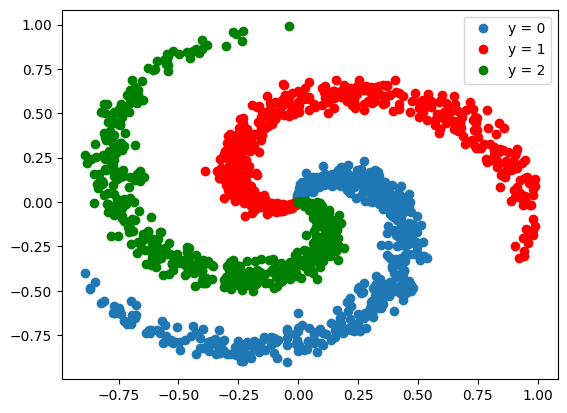

In [7]:
# Create a Dataset object

data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

Create a  network to classify three classes with 1 hidden layer with 50 neurons 


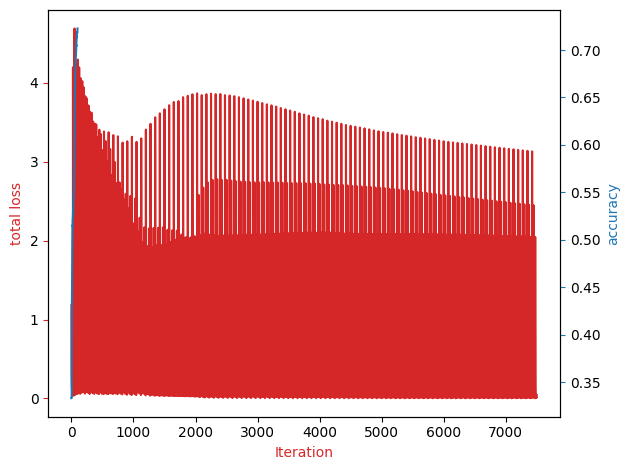

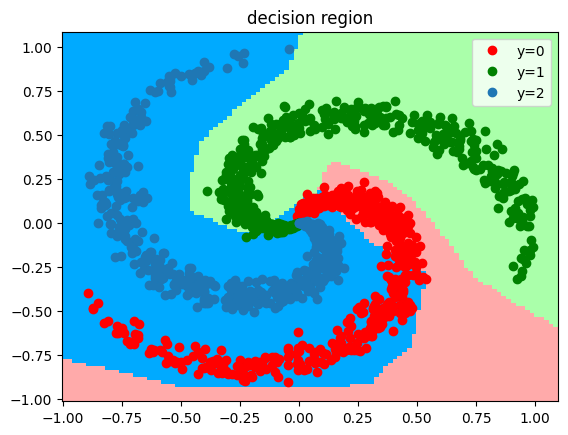

In [8]:
# Train the model with 1 hidden layer with 50 neurons

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs=100)

plot_decision_regions_3class(model, data_set)

Create a  network to classify three classes with 2 hidden layers with 20 neurons in total 


In [9]:
Net([3,3,4,3]).parameters

<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=3, bias=True)
  )
)>

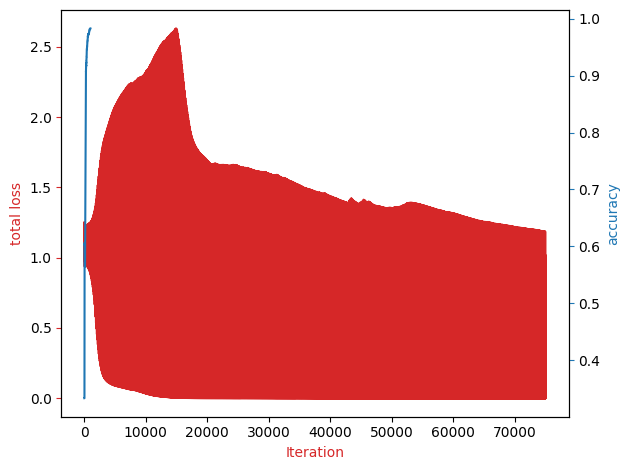

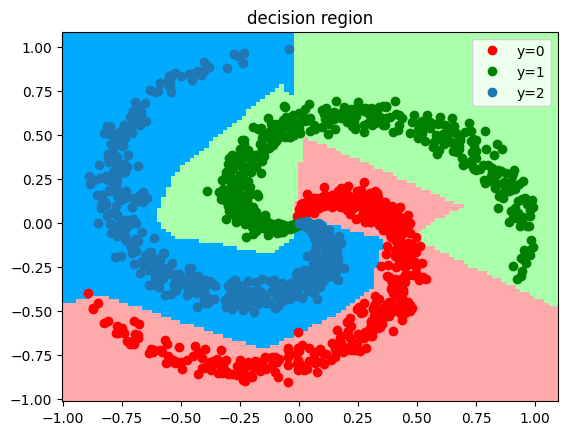

In [10]:
# Train the model with 2 hidden layers with 20 neurons

Layers = [2, 10, 10, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs=1000)

plot_decision_regions_3class(model, data_set)

<h3>Practice</h3>


Create a network with three hidden layers each with ten neurons, then train the network using the same process as above 


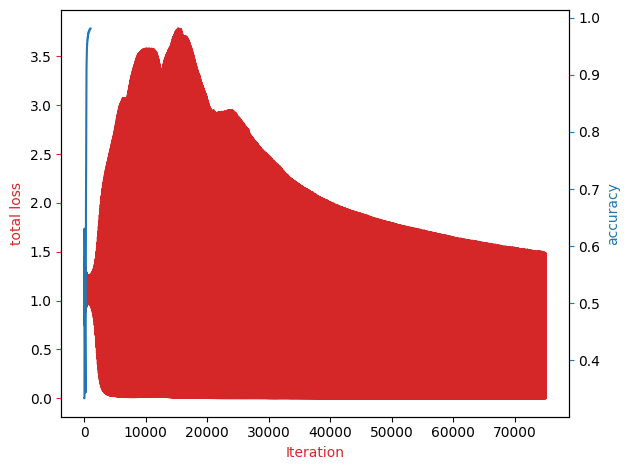

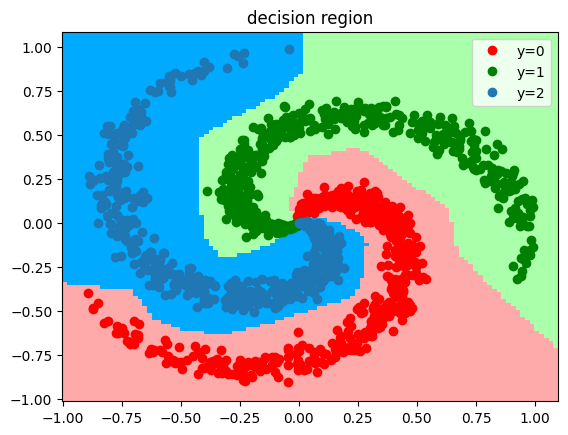

In [19]:
# Practice: Create a network with three hidden layers each with ten neurons.

# Type your code here

Layers = [2, 10, 10, 10, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs=1000)

plot_decision_regions_3class(model, data_set)

Double-click <b>here</b> for the solution.

<!-- 
Layers = [2, 10, 10, 10, 3]
model = Net(Layers)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 1000)
plot_decision_regions_3class(model, data_set)
-->




<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>
-->

## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
